# 1.2. Tabular Policy Gradient (REINFORCE)
## Discrete state, discrete action problem

Simple dicrete gridworld environment that can be solved with a tabular Reinforcement Learning (RL)

In [1]:
# import env and modules
import gym
import numpy as np
import myenv
import inspect
import service_functions as sf

In [2]:
# create an instance of env
env = myenv.SimpleGridWorldEnv()
env.render()
print('Env step return (state,reward,done):',env.step(env.action_space.sample()))

The environment is initialized
This is a simple grid-world env 5x5 with 1x25 state.
You can render it with .render()
[[0. 1. 0. 3. 0.]
 [0. 0. 0. 0. 0.]
 [0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]]
Env step return (state,reward,done): (10, 0, False, {})


### Policy-based algorithms in Reinforcement Learning (RL)

Policy Learning (Policy Gradient) is family of algorithms in RL.

The policy model (or behavior model) stores the information about the probability of action that should be taken in any given state in order to maximize the outcome. In this example, it is stored as a table of values).

In [3]:
# use stable softmax with normalization to compute the probabily of the action
print(inspect.getsource(sf.softmax))

def softmax(x):
    """ stable softmax with normalization"""
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)



In [4]:
# gradient function for softmax used here is just a difference between true action taken and probability of this action
print(inspect.getsource(sf.gradient))

def gradient(policy, s_arr, a_arr, r_arr):
    """ gradient function for softmax given single trajectory (based on lecture notes)"""
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * r_arr[t] #accumulate gradients through trajectory
    return g



In [5]:
# use discounted reward for trajectory (WITH CAUSALITY) 
print(inspect.getsource(sf.discount_rewards))

def discount_rewards(r_arr, gamma):
    """ function to discount reward in trajectory (WITH CAUSALITY)"""
    discounted_reward = np.zeros_like(r_arr)
    running_reward = 0
    for t in reversed(range(len(r_arr))):
        running_reward = running_reward*gamma + r_arr[t]
        discounted_reward[t] = running_reward
    return discounted_reward



### Policy Gradient (REINFORCE algorithm)

In [6]:
# PG REINFORCE algorithm
def PolicyGrad():
    stats = []
    
    # policy table init
    #policy = np.zeros([env.observation_space.n, env.action_space.n])
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    grad_buffer = np.zeros_like(policy)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()
        trajectory = []
            
        for t in range(episode_lenght):
        
            a_distr = sf.softmax(policy[s]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s,a,r])
                
            s = s_prime
            r_total += r
                
            if d:
                break
                     
        # update gradient buffer with new trajectory
        s_arr, a_arr, r_arr = zip(*trajectory)
        r_arr = sf.discount_rewards(r_arr, gamma)
        grad = sf.gradient(policy, s_arr, a_arr, r_arr)
        grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
        
        if i_episode % update_freq == 0 and i_episode!=0:
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
                    
        # Update statistics
        r_total /= t
        stats.append([i_episode,r_total])
        sf.print_progress(i_episode,n_episodes-1, r_total)
        
    return policy, stats

In [7]:
# initialize hyperparams for PG
n_episodes = 1000
episode_lenght = 100
gamma = 0.9
alpha = 0.05
update_freq = 10

In [8]:
# run the algorithm to get statistics (simple env)
env.stochastic_transitions = True
policy, stats_pg_stoch = PolicyGrad()

env.stochastic_transitions = False
_, stats_pg_determ = PolicyGrad()

print("Policy (simple case):")
sf.print_policy(policy)

 |██████████████████████████████████████████████████| Progress:100.0% Val:1.9191919191919191  
 |██████████████████████████████████████████████████| Progress:100.0% Val:2.0202020202020203 
Policy (simple case):
⇨⇩⇦⇦⇦
⇧⇧⇦⇧⇦
⇧⇧⇧⇧⇦
⇧⇧⇧⇦⇧
⇨⇧⇧⇧⇧



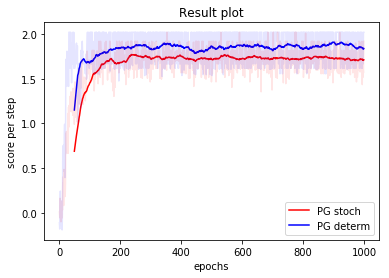

In [10]:
sf.plot_results([stats_pg_stoch,stats_pg_determ],['PG stoch','PG determ'], average_over=50)